<a href="https://colab.research.google.com/github/satoyume13/Notch-Tech-AI-Task/blob/main/Notch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Install necessary libraries
!pip install torch transformers pillow
!pip install ultralytics
!pip install ultralytics transformers matplotlib
!pip install ensemble-boxes
!pip install ultralytics transformers ensemble-boxes matplotlib





In [7]:
from google.colab import drive
import os
import json
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from ensemble_boxes import *
from ensemble_boxes import weighted_boxes_fusion
from collections import Counter

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Load YOLOv8 Extra Large for High-Accuracy Object Detection
yolo_model = YOLO('yolov8x6.pt')

# Load FLAN-T5 for Caption Generation
flan_model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(flan_model_name)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(flan_model_name).to("cuda" if torch.cuda.is_available() else "cpu")




Processing: /content/drive/MyDrive/test images/2.jpg
Detecting objects in image: /content/drive/MyDrive/test images/2.jpg

image 1/1 /content/drive/MyDrive/test images/2.jpg: 1728x2560 23 persons, 2 bicycles, 3 cars, 4 backpacks, 2 handbags, 1 cup, 64619.8ms
Speed: 206.8ms preprocess, 64619.8ms inference, 48.8ms postprocess per image at shape (1, 3, 1728, 2560)


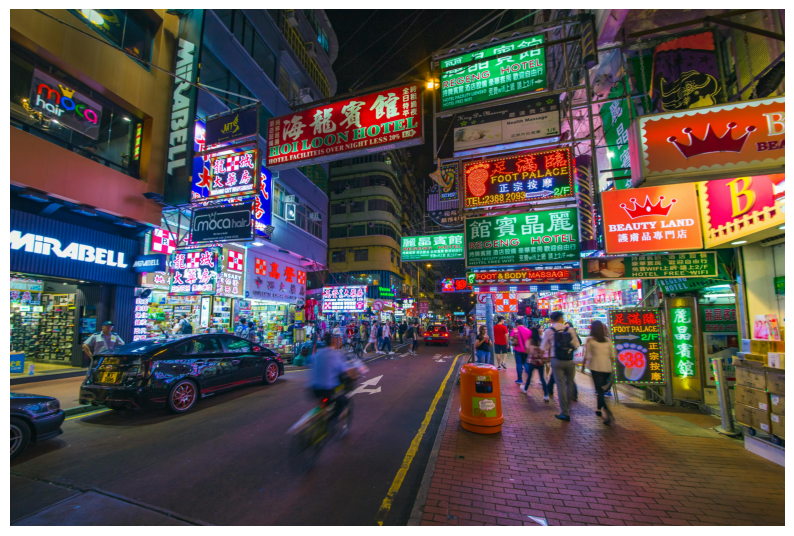

/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:45: UserWarning: X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:66: UserWarning: Zero area box skipped: [1.0247031094735128, 0.3893123872098867, 1.1047837106805098, 0.5321062322248492].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:66: UserWarning: Zero area box skipped: [1.1052474975585938, 0.40011922378986203, 1.1707688716419957, 0.5359983388443439].
  warnin

Detected labels for /content/drive/MyDrive/test images/2.jpg: ['car', 'car', 'car', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'backpack', 'bicycle', 'person', 'backpack', 'backpack', 'cup', 'person', 'bicycle', 'handbag', 'person', 'person', 'person', 'person', 'person', 'person', 'person']
Generated prompt for FLAN-T5: The image contains: 3 car, 21 person, 3 backpack, 2 bicycle, cup, handbag. Describe the scene factually, highlighting the relationships between objects if implied. 
Generated caption: A group of people are walking around a city with a car , backpack , bicycle , cup and handbag.


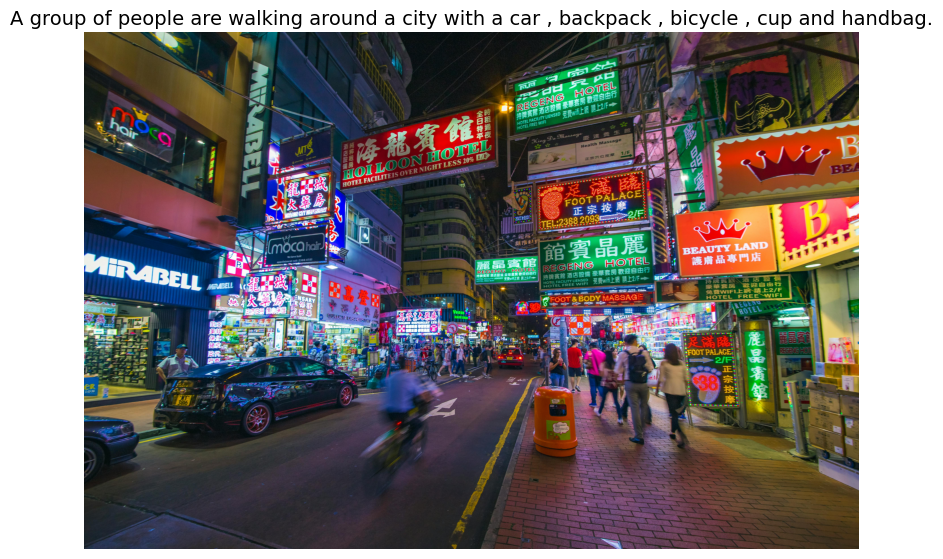


Processing: /content/drive/MyDrive/test images/1.jpg
Detecting objects in image: /content/drive/MyDrive/test images/1.jpg

image 1/1 /content/drive/MyDrive/test images/1.jpg: 1728x2560 1 bench, 60370.6ms
Speed: 67.9ms preprocess, 60370.6ms inference, 9.0ms postprocess per image at shape (1, 3, 1728, 2560)


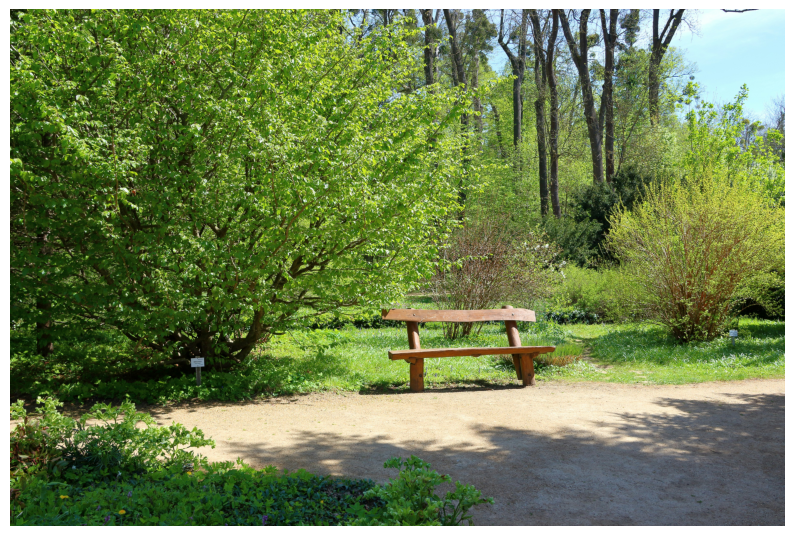

Detected labels for /content/drive/MyDrive/test images/1.jpg: ['bench']
Generated prompt for FLAN-T5: The image contains: bench. Describe the scene factually, highlighting the relationships between objects if implied. 
Generated caption: A bench in a park with a tree and a lion on it.


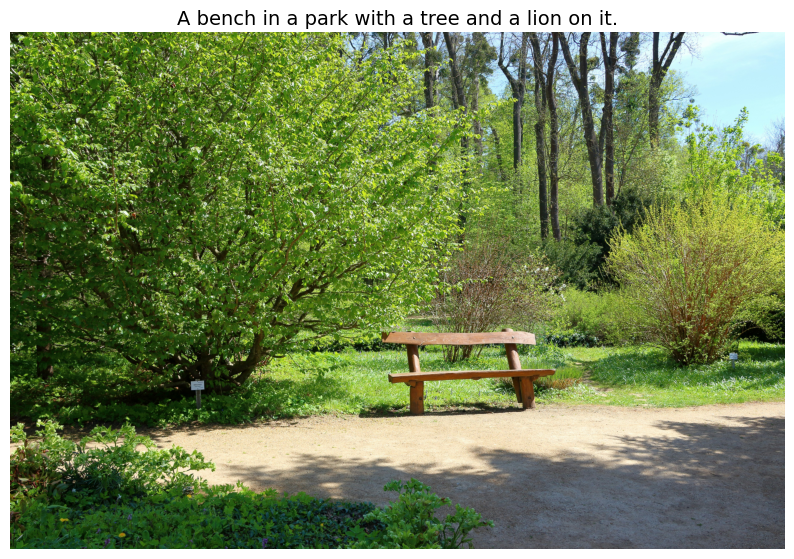


Processing: /content/drive/MyDrive/test images/3.jpg
Detecting objects in image: /content/drive/MyDrive/test images/3.jpg

image 1/1 /content/drive/MyDrive/test images/3.jpg: 1920x2560 1 cat, 2 laptops, 65812.6ms
Speed: 74.7ms preprocess, 65812.6ms inference, 10.3ms postprocess per image at shape (1, 3, 1920, 2560)


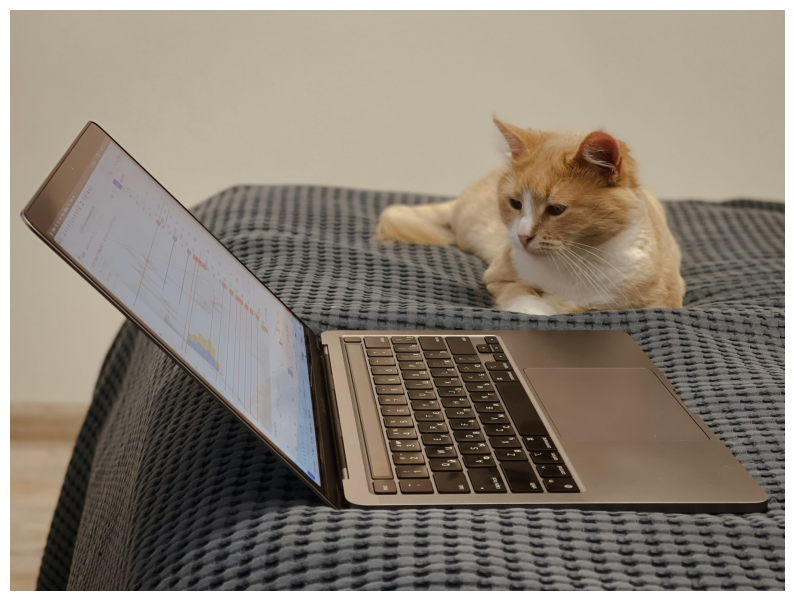

Detected labels for /content/drive/MyDrive/test images/3.jpg: ['cat', 'laptop', 'laptop']
Generated prompt for FLAN-T5: The image contains: cat, 2 laptop. Describe the scene factually, highlighting the relationships between objects if implied. 
Generated caption: A cat and a laptop.


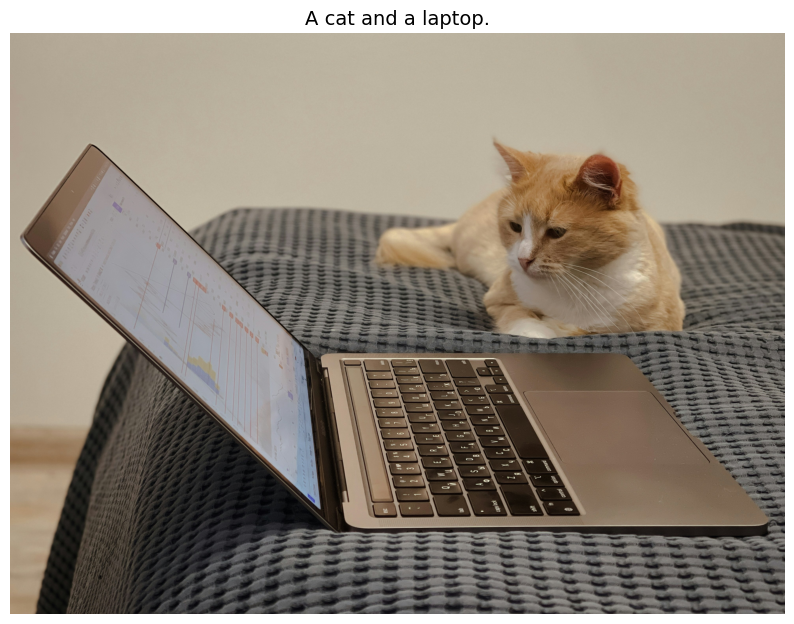


Results saved to captions_with_factual_descriptions.json


In [9]:
def debug_plot_detections(image_path, results):
    """
    Plot detected objects on the image for visual verification.
    Args:
        image_path (str): Path to the image file.
        results (Results): YOLOv8 results object.
    """
    results[0].plot()  # Overlay detections on the image
    plt.figure(figsize=(10, 8))
    plt.imshow(mpimg.imread(image_path))
    plt.axis('off')
    plt.show()


def detect_objects(image_path, conf_threshold=0.2, iou_threshold=0.5, imgsz=2560):
    """
    Detect objects in an image using YOLOv8 with WBF for improved accuracy.
    Args:
        image_path (str): Path to the image file.
        conf_threshold (float): Minimum confidence threshold for detections.
        iou_threshold (float): IoU threshold for non-max suppression.
        imgsz (int): Input image size for inference.
    Returns:
        List[str]: List of detected object names (labels).
    """
    print(f"Detecting objects in image: {image_path}")
    results = yolo_model(image_path, conf=conf_threshold, iou=iou_threshold, imgsz=imgsz)

    # Plot detections for debugging
    debug_plot_detections(image_path, results)

    boxes, scores, labels = [], [], []
    detected_labels = []

    for result in results:
        for i, cls_tensor in enumerate(result.boxes.cls):
            cls_id = int(cls_tensor.item())
            label = result.names[cls_id]
            confidence = float(result.boxes.conf[i].item())
            bbox = result.boxes.xyxy[i].tolist()

            boxes.append(bbox)
            scores.append(confidence)
            labels.append(cls_id)
            detected_labels.append(label)

    # Normalize bounding boxes to [0, 1] range for WBF
    if boxes:
        image_width, image_height = results[0].orig_shape[:2]
        boxes = [[
            box[0] / image_width,
            box[1] / image_height,
            box[2] / image_width,
            box[3] / image_height
        ] for box in boxes]

    # Apply WBF if there are multiple detections
    if len(boxes) > 1:
        fused_boxes, fused_scores, fused_labels = weighted_boxes_fusion(
            [boxes], [scores], [labels], iou_thr=0.5, weights=None
        )
        detected_labels = [results[0].names[int(cls_id)] for cls_id in fused_labels]

    print(f"Detected labels for {image_path}: {detected_labels}")
    return detected_labels


def preprocess_labels(detected_labels):
    """
    Consolidate detected labels into counts for a concise prompt.
    Args:
        detected_labels (List[str]): List of detected object labels.
    Returns:
        str: Consolidated label string with counts.
    """
    label_counts = Counter(detected_labels)
    consolidated_labels = [f"{count} {label}" if count > 1 else label for label, count in label_counts.items()]
    return ", ".join(consolidated_labels)


def generate_caption_with_llm(detected_labels):
    """
    Generate a descriptive caption using FLAN-T5 based on detected labels.
    Args:
        detected_labels (List[str]): List of detected object labels.
    Returns:
        str: Generated caption.
    """
    if not detected_labels:
        return "The image appears abstract or does not contain recognizable objects."

    consolidated_labels = preprocess_labels(detected_labels)
    prompt = (
        f"The image contains: {consolidated_labels}. "
        "Describe the scene factually, highlighting the relationships between objects if implied. "
    )
    print(f"Generated prompt for FLAN-T5: {prompt}")

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
    outputs = flan_model.generate(
        **inputs,
        max_length=150,
        temperature=0.5,  # Balanced randomness
        top_p=0.8,
        do_sample=True
    )
    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Generated caption: {caption}")

    return caption


def display_image_with_caption(image_path, caption):
    """
    Display the image with its generated caption.
    Args:
        image_path (str): Path to the image file.
        caption (str): Generated caption for the image.
    """
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(caption, wrap=True, fontsize=14)
    plt.axis('off')
    plt.show()


def process_images(image_folder, output_file="captions_with_factual_descriptions.json"):
    """
    Process all images in a folder, generate captions based on detection and prediction, display images, and export results.
    Args:
        image_folder (str): Path to the folder containing images.
        output_file (str): File path to save the results as JSON.
    """
    if not os.path.exists(image_folder):
        print(f"Error: Folder '{image_folder}' not found!")
        return

    images = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not images:
        print("No images found in the folder.")
        return

    results = []
    for image_path in images:
        print(f"\nProcessing: {image_path}")
        try:
            detected_labels = detect_objects(image_path)
            caption = generate_caption_with_llm(detected_labels)
            display_image_with_caption(image_path, caption)
            results.append({"image": os.path.basename(image_path), "caption": caption, "objects": detected_labels})
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    # Save results to JSON
    with open(output_file, "w") as f:
        json.dump(results, f, indent=4)
    print(f"\nResults saved to {output_file}")
if __name__ == "__main__":
    image_folder = "/content/drive/MyDrive/test images"  # Update with your folder path
    output_file = "captions_with_factual_descriptions.json"
    process_images(image_folder, output_file)
